In [2]:
import matplotlib.pyplot as plt
import astropy.io.fits as ast
import numpy as np
import csv
import time
from pprint import pprint

from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename 

from photutils import centroid_com

print("Required Libraries Loaded Successfully...")

%matplotlib inline
plt.ion()
print("Matplotlib Intialised...")

import tools
print("Imported Oliver King's Planetary Science Tools Successfully...")

def AU_to_km(n):
    Dist = n*149598000
    return Dist
print("Defined all Necessary Unit Conversion Routines...")

crosshaircol = 'red'
imgcolourmap = 'bone'
print('Graphical Parameters Initialised...')

print("\nAll Modules Imported Successfully!")

Required Libraries Loaded Successfully...
Matplotlib Intialised...
Imported Oliver King's Planetary Science Tools Successfully...
Defined all Necessary Unit Conversion Routines...
Graphical Parameters Initialised...

All Modules Imported Successfully!


# Cell which imports and calibrates the images

Image Read Successfully 

The I/F Factor has been calculated to be: 0.0001682257583750803
The OPAL I/F Factor is: 0.00475
Use the OPAL I/F(opal), Calculated I/F(calc) or no calibration(no input)? :>calc

Data Calibrated with Calculated I/F Factor successfully.


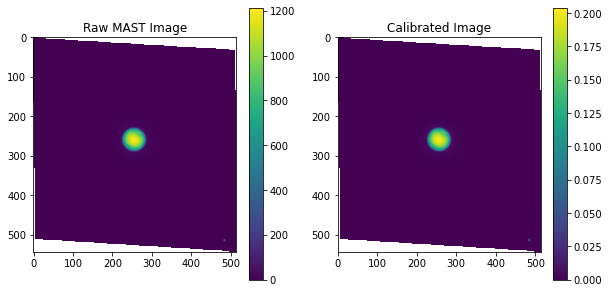

In [3]:
#---------------------------------------------------------------------------------------------------------------
#                                      Reading in an Image From the MAST Archive
#---------------------------------------------------------------------------------------------------------------
file = get_pkg_data_filename('OPAL RAWS/Cycle_26/1/F467M/467_1_drz.fits')
fitsdata = fits.open(file)
imgdata = fits.getdata(file, ext=1)
resolution = imgdata.shape
fitshdr = fitsdata[0].header
scihdr = fitsdata[1].header
ephemeris = tools.mapping.get_ephemerides(target = 'neptune', loc = 'hst', epoch = fitshdr['EXPSTART'])

#pprint(vars(ephemeris))

print('Image Read Successfully \n')
time.sleep(1)


#---------------------------------------------------------------------------------------------------------------
#                                      Reading in an Image From the MAST Archive
#---------------------------------------------------------------------------------------------------------------
#Defines the constants needed to calculate I/F conversion factor that are based on the WFC3/UVIS Instrument
#PixWidth = plate scale of WFC3/UVIS, taken from Amy Simon's Uranus Spreadsheet, and checked with the WFC3 Manual
PixWidth = 0.04 #arcseconds 
#omega = Solid Angle of a Single WFC3/UVIS Pixel
omega = ((PixWidth/3600)*(np.pi/180))**2 #steradians
ephdist = ephemeris['r']
dist = float(ephdist)
PHOTFLAM = 4.5375e-19
SolFlux = 2019.04
fractop = ((PHOTFLAM*10)/omega)
fracbottom = ((AU_to_km(1.0)/AU_to_km(dist))**2)*(SolFlux/np.pi)
IF_Factor = fractop/fracbottom
OPAL_IF = 0.00475

print('The I/F Factor has been calculated to be:',str(IF_Factor))
print('The OPAL I/F Factor is:', str(OPAL_IF))

UseOPAL = input('Use the OPAL I/F(opal), Calculated I/F(calc) or no calibration(no input)? :>')

while UseOPAL not in {'opal','calc',''}:
    UseOPAL = input('Invalid Input. Please enter string as seen in the prompt :> ')

if UseOPAL == 'opal':
    img = imgdata*OPAL_IF
    print('\nData Calibrated with OPAL I/F Factor successfully.')
elif UseOPAL == 'calc':
    img = imgdata*IF_Factor
    print('\nData Calibrated with Calculated I/F Factor successfully.')
else:
    img = imgdata
    print('\nData left Uncalibrated.')

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
im = ax1.imshow(imgdata, cmap='viridis')
plt.title('Raw MAST Image')
plt.colorbar(im)
ax2 = plt.subplot(122)
im2 = ax2.imshow(img, cmap='viridis')
plt.title('Calibrated Image')
plt.colorbar(im2)

# Cell which navigates the MAST image

First guess at the planicentre: [256.63054648 259.60992971]
(33.56639796351294, 33.21849809079338, 29.455074999999997)
[33.51672785 33.23260738]


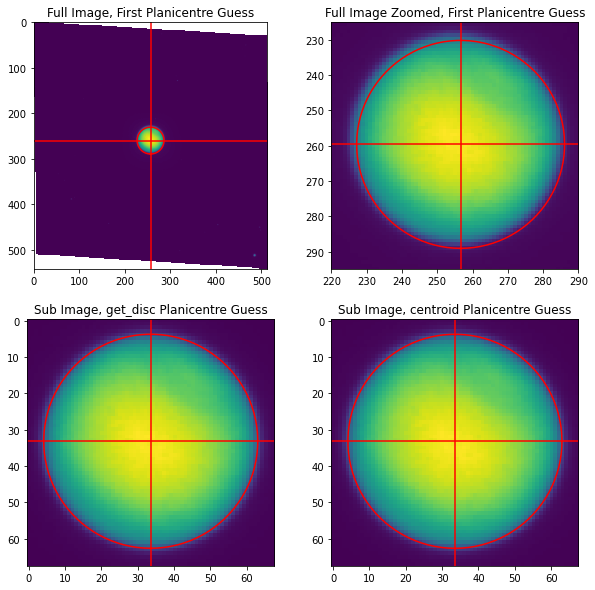

In [4]:
def circ(img, rad):
    theta = np.linspace(0, 2*np.pi, 100)
    r = np.sqrt(rad**2)
    y = r*np.cos(theta)
    x = r*np.sin(theta)
    return(img, y, x)

rad = float(ephemeris['ang_width'])/(2*PixWidth)
img, y, x = circ(img, rad)
planicentre1 = centroid_com(img) # index 0=x direction, index 1=y direction

print('First guess at the planicentre:',str(planicentre1))

DiscImg = img[(int(planicentre1[1])-(int(rad)+5)):(int(planicentre1[1])+(int(rad)+5)),(int(planicentre1[0])-(int(rad)+5)):int(planicentre1[0])+((int(rad)+5))]

planicentre2 = tools.mapping.get_disc(DiscImg, r0=rad)
planicentre3 = centroid_com(DiscImg)
print(planicentre2)
print(planicentre3)

#plots showing the navigation of the image
plt.figure(figsize=(10,10))
ax1 = plt.subplot(221)
ax1.imshow(img)
plt.title('Full Image, First Planicentre Guess')
ax1.axhline(planicentre1[1],color=crosshaircol)
ax1.axvline(planicentre1[0],color=crosshaircol)
ax1.plot(x+planicentre1[0], y+planicentre1[1],color=crosshaircol)
ax2 = plt.subplot(222)
ax2.imshow(img)
plt.title('Full Image Zoomed, First Planicentre Guess')
plt.xlim(220,290)
plt.ylim(295,225)
ax2.axhline(planicentre1[1],color=crosshaircol)
ax2.axvline(planicentre1[0],color=crosshaircol)
ax2.plot(x+planicentre1[0], y+planicentre1[1],color=crosshaircol)
ax3 = plt.subplot(223)
ax3.imshow(DiscImg)
plt.title('Sub Image, get_disc Planicentre Guess')
ax3.axhline(planicentre2[1],color=crosshaircol)
ax3.axvline(planicentre2[0],color=crosshaircol)
ax3.plot(x+planicentre2[0], y+planicentre2[1],color=crosshaircol)
ax4 = plt.subplot(224)
ax4.imshow(DiscImg)
plt.title('Sub Image, centroid Planicentre Guess')
ax4.axhline(planicentre3[1],color=crosshaircol)
ax4.axvline(planicentre3[0],color=crosshaircol)
ax4.plot(x+planicentre3[0], y+planicentre3[1],color=crosshaircol)

# Cell which Maps the image (no minnaert correction)

.

C:\Users\jamie\Documents\Uni Work\Year 4\PA4900 Specialist Research Project\CODE AHHHHHHH\Neptune from Scratch\IMAGE MAPPING\Experimenting with Mapping\tools\mapping.py:331: RuntimeWarning: invalid value encountered in sqrt
  z_img = np.sqrt(1 - x_img**2 - y_img**2)
C:\Users\jamie\Documents\Uni Work\Year 4\PA4900 Specialist Research Project\CODE AHHHHHHH\Neptune from Scratch\IMAGE MAPPING\Experimenting with Mapping\tools\mapping.py:527: RuntimeWarning: invalid value encountered in remainder
  long_img = long_img % (2*np.pi)  # ensure values are in expected range


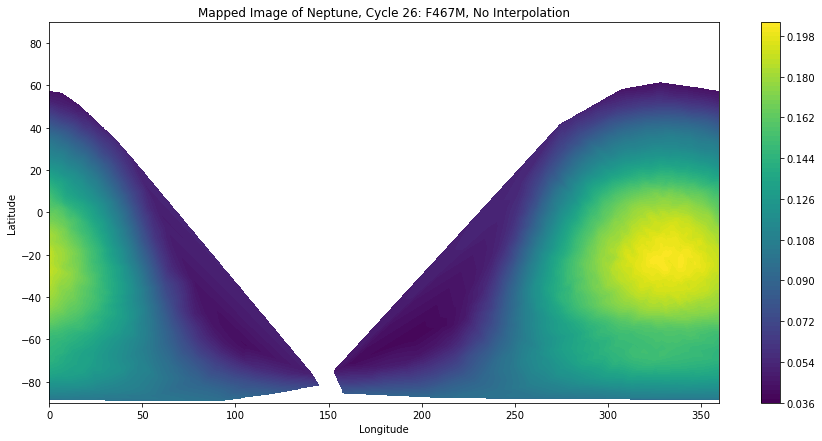

In [5]:
rDisc = planicentre2[2]
AxisAng = float(ephemeris['NPole_ang'])
obs_long = float(ephemeris['PDObsLon'])
obs_lat = float(ephemeris['PDObsLat'])

#DiscImg is a subarray of the full image containing just the planet, currently not been interpolated, therefore it is very
#pixellated. planicentre2 is an object containing the results from the get_disc routine.

#equirectangularmap = tools.mapping.map_observation(DiscImg, 33.56639796351294, 33.21849809079338,
#                                                 rDisc, AxisAng, obs_long, obs_lat)

long_img, lat_img = tools.mapping.img_to_longlat(DiscImg.shape, planicentre2[0], planicentre2[1],
                                                 rDisc, AxisAng, obs_long, obs_lat)
equirectangularmap = tools.mapping.longlat_to_map(DiscImg, long_img, lat_img, obs_long = obs_long)

#plt.figure(figsize=(15,7))
#plt.imshow(equirectangularmap[0])
#plt.colorbar()

plt.figure(figsize=(15,7))
plt.contourf(equirectangularmap[1], equirectangularmap[2], equirectangularmap[0], levels=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapped Image of Neptune, Cycle 26: F467M, No Interpolation')
plt.colorbar()

# Minnaert Correction Function

In [6]:
def minnaert(img, cent, k, ex_ang=70):
    """
    Function which applies a Minnaert Function Correction to an image, removing limb darkening
    Inputs are:
    - img: the cropped image of the planetary disc
    - cent: the planicentre and radius of the disc, as given by the get_disc routine from Oliver King
    - k: the minnaert parameter to be applied to the image
    - ex_ang: the emission angle from which to exclude the outer edges of the disc, default value 70 degrees
    
    Outputs are:
    - img_corr: the Minnaert Corrected image of the disc
    """
    #Shielding from unexpected forms of inputs for k
    k = float(k)
    
    #find the theta and phi coordinate images for the disc
    x, y, z = tools.mapping.img_to_xyz(img.shape, cent[0], cent[1], cent[2])
    theta, phi = tools.mapping.xyz_to_thetaphi(x, y, z)
    
    #get the mu parameter image
    mu = np.cos(theta*(np.pi/180))
    
    #apply the correction to the image
    img_corr = img*(mu**(k-1))*(mu**k)
    img_corr[theta>ex_ang] = np.nan #trims the extreme edges of the planetary disc off
    return img_corr

Image Read Successfully 

The I/F Factor has been calculated to be: 0.0001682257583750803
The OPAL I/F Factor is: 0.00475
Use the OPAL I/F(opal), Calculated I/F(calc) or no calibration(no input)? :>calc

Data Calibrated with Calculated I/F Factor successfully.
First guess at the planicentre: [256.63054648 259.60992971]
.

C:\Users\jamie\Documents\Uni Work\Year 4\PA4900 Specialist Research Project\CODE AHHHHHHH\Neptune from Scratch\IMAGE MAPPING\Experimenting with Mapping\tools\mapping.py:331: RuntimeWarning: invalid value encountered in sqrt
  z_img = np.sqrt(1 - x_img**2 - y_img**2)
C:\Users\jamie\Documents\Uni Work\Year 4\PA4900 Specialist Research Project\CODE AHHHHHHH\Neptune from Scratch\IMAGE MAPPING\Experimenting with Mapping\tools\mapping.py:331: RuntimeWarning: invalid value encountered in sqrt
  z_img = np.sqrt(1 - x_img**2 - y_img**2)
C:\Users\jamie\Documents\Uni Work\Year 4\PA4900 Specialist Research Project\CODE AHHHHHHH\Neptune from Scratch\IMAGE MAPPING\Experimenting with Mapping\tools\mapping.py:527: RuntimeWarning: invalid value encountered in remainder
  long_img = long_img % (2*np.pi)  # ensure values are in expected range


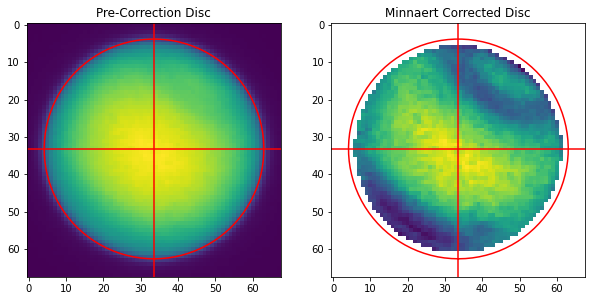

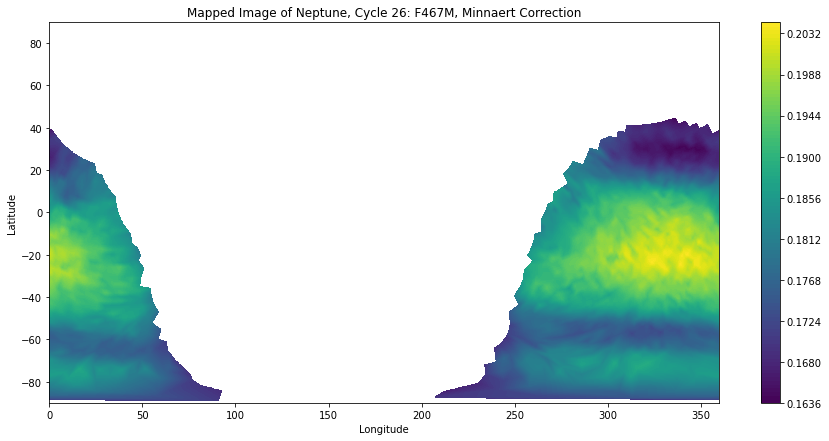

In [7]:
#---------------------------------------------------------------------------------------------------------------
#                                      Reading in an Image From the MAST Archive
#---------------------------------------------------------------------------------------------------------------
file = get_pkg_data_filename('OPAL RAWS/Cycle_26/1/F467M/467_1_drz.fits')
fitsdata = fits.open(file)
imgdata = fits.getdata(file, ext=1)
resolution = imgdata.shape
fitshdr = fitsdata[0].header
scihdr = fitsdata[1].header
ephemeris = tools.mapping.get_ephemerides(target = 'neptune', loc = 'hst', epoch = fitshdr['EXPSTART'])

#pprint(vars(ephemeris))

print('Image Read Successfully \n')
time.sleep(1)


#---------------------------------------------------------------------------------------------------------------
#                                      Reading in an Image From the MAST Archive
#---------------------------------------------------------------------------------------------------------------
#Defines the constants needed to calculate I/F conversion factor that are based on the WFC3/UVIS Instrument
#PixWidth = plate scale of WFC3/UVIS, taken from Amy Simon's Uranus Spreadsheet, and checked with the WFC3 Manual
PixWidth = 0.04 #arcseconds 
#omega = Solid Angle of a Single WFC3/UVIS Pixel
omega = ((PixWidth/3600)*(np.pi/180))**2 #steradians
ephdist = ephemeris['r']
dist = float(ephdist)
PHOTFLAM = 4.5375e-19
SolFlux = 2019.04
fractop = ((PHOTFLAM*10)/omega)
fracbottom = ((AU_to_km(1.0)/AU_to_km(dist))**2)*(SolFlux/np.pi)
IF_Factor = fractop/fracbottom
OPAL_IF = 0.00475

print('The I/F Factor has been calculated to be:',str(IF_Factor))
print('The OPAL I/F Factor is:', str(OPAL_IF))

UseOPAL = input('Use the OPAL I/F(opal), Calculated I/F(calc) or no calibration(no input)? :>')

while UseOPAL not in {'opal','calc',''}:
    UseOPAL = input('Invalid Input. Please enter string as seen in the prompt :> ')

if UseOPAL == 'opal':
    img = imgdata*OPAL_IF
    print('\nData Calibrated with OPAL I/F Factor successfully.')
elif UseOPAL == 'calc':
    img = imgdata*IF_Factor
    print('\nData Calibrated with Calculated I/F Factor successfully.')
else:
    img = imgdata
    print('\nData left Uncalibrated.')

rad = float(ephemeris['ang_width'])/(2*PixWidth)
img, y, x = circ(img, rad)
planicentre1 = centroid_com(img) # index 0=x direction, index 1=y direction

print('First guess at the planicentre:',str(planicentre1))

DiscImg = img[(int(planicentre1[1])-(int(rad)+5)):(int(planicentre1[1])+(int(rad)+5)),(int(planicentre1[0])-(int(rad)+5)):int(planicentre1[0])+((int(rad)+5))]

planicentre2 = tools.mapping.get_disc(DiscImg, r0=rad)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax1.imshow(DiscImg)
plt.title('Pre-Correction Disc')
ax1.axhline(planicentre2[1],color=crosshaircol)
ax1.axvline(planicentre2[0],color=crosshaircol)
ax1.plot(x+planicentre2[0], y+planicentre2[1],color=crosshaircol)

DiscImg = minnaert(DiscImg, planicentre2, 0.185)

ax2 = plt.subplot(122)
ax2.imshow(DiscImg)
plt.title('Minnaert Corrected Disc')
ax2.axhline(planicentre2[1],color=crosshaircol)
ax2.axvline(planicentre2[0],color=crosshaircol)
ax2.plot(x+planicentre2[0], y+planicentre2[1],color=crosshaircol)

long_img, lat_img = tools.mapping.img_to_longlat(DiscImg.shape, planicentre2[0], planicentre2[1],
                                                 rDisc, AxisAng, obs_long, obs_lat)
equirectangularmap = tools.mapping.longlat_to_map(DiscImg, long_img, lat_img, obs_long = obs_long)

plt.figure(figsize=(15,7))
plt.contourf(equirectangularmap[1], equirectangularmap[2], equirectangularmap[0], levels=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapped Image of Neptune, Cycle 26: F467M, Minnaert Correction')
plt.colorbar()